In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

# Data

The data used in this document was obtained from the Kaggle competition Addison Howard, Chris Balbach, Clayton Miller, Jeff Haberl, Krishnan Gowri, Sohier Dane. (2019). ASHRAE - Great Energy Predictor III. Kaggle. Raw data are available for download after registration at Kaggle platform.

In [2]:
# Load data
data = pd.read_parquet("./data/processed/data.parquet")
display(data.head())
display(data.dtypes)

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,29,2016-01-06,0.000000,0,Education,113866,2006,<NA>,15.525000,7.5,12.433333,-0.083333,1022.454167,214.166667,5.404167
1,29,2016-01-07,577.445984,0,Education,113866,2006,<NA>,16.491667,6.8,13.970833,-0.166667,1017.112500,294.090909,4.045833
2,29,2016-01-08,0.000000,0,Education,113866,2006,<NA>,17.475000,8.2,16.050000,3.041667,1013.713636,82.500000,1.962500
3,29,2016-01-09,0.000000,0,Education,113866,2006,<NA>,17.341667,7.3,16.020833,0.125000,1012.195833,82.916667,2.241667
4,29,2016-01-10,0.000000,0,Education,113866,2006,<NA>,19.250000,7.5,16.575000,2.208333,1012.087500,228.750000,4.008333


building_id                    Int32
timestamp             datetime64[ns]
meter_reading                float32
site_id                        Int32
primary_use                 category
square_feet                    Int32
year_built                     Int32
floor_count                    Int32
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

# Exploratory data analysis and additional processing

## Building primary use¶

One of the key attributes associated with each building is its designated use. This feature may play a crucial role in influencing the energy consumption pattern, as distinct uses can significantly impact both the quantity and timing of energy consumption.

In [3]:
# Number of buildings and type of buildings based on primary use
n_building = data["building_id"].nunique()
n_type_building = data["primary_use"].nunique()

# Each building has one primary use
count_primary_use = data.drop_duplicates(subset=["building_id"])[
    "primary_use"
].value_counts()

print(f"Number of buildings: {n_building}")
print(f"Number of building types: {n_type_building}")
display(count_primary_use)

Number of buildings: 1277
Number of building types: 16


primary_use
Education                        490
Office                           240
Entertainment/public assembly    168
Public services                  154
Lodging/residential              118
Other                             20
Healthcare                        19
Parking                           14
Warehouse/storage                 12
Manufacturing/industrial          10
Services                           9
Technology/science                 6
Food sales and service             5
Retail                             5
Utility                            4
Religious worship                  3
Name: count, dtype: int64

For certain primary use categories, there is a limited number of buildings within the dataset. To streamline the analysis, categories with fewer than 100 buildings are grouped into the "Other" category.

Types of buildings (primary use) with less than 100 samples are grouped as "Other".


In [4]:
infrequent_categories = count_primary_use[count_primary_use < 100].index.to_list()

print(f"Infequent categories:")
print("======================")
print("\n".join(infrequent_categories))

data["primary_use"] = np.where(
    data["primary_use"].isin(infrequent_categories), "Other", data["primary_use"]
)
data["primary_use"] = data["primary_use"].astype("category")

Infequent categories:
Other
Healthcare
Parking
Warehouse/storage
Manufacturing/industrial
Services
Technology/science
Food sales and service
Retail
Utility
Religious worship


In [7]:
data.groupby("building_id")["meter_reading"].mean().sort_values(ascending=False)

building_id
801     111565.921875
794      98978.132812
1088     82193.601562
797      74520.187500
223      59906.730469
            ...      
808          6.672151
845          6.175305
637          4.742367
636          4.424654
740          0.009599
Name: meter_reading, Length: 1277, dtype: float32

/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_45468/2144263624.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("primary_use")["building_id"]


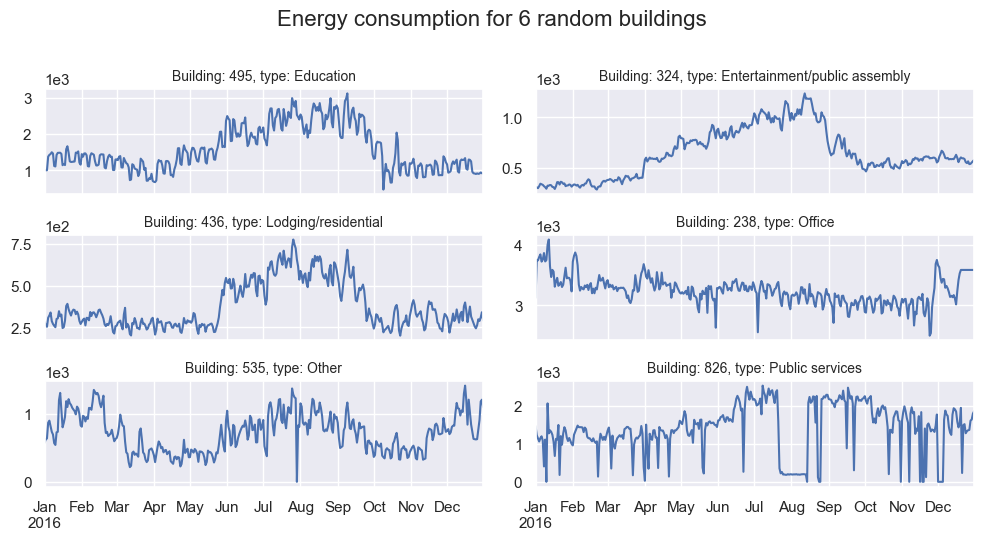

In [8]:
# Time series for 1 random selected building per group
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 5.5), sharex=True, sharey=False)
sample_ids = (
    data.groupby("primary_use")["building_id"]
    .apply(lambda x: x.sample(1, random_state=42))
    .tolist()
)
axs = axs.flatten()

for i, building_id in enumerate(sample_ids):
    data_sample = data[data["building_id"] == building_id]
    building_type = data_sample["primary_use"].unique()[0]
    data_sample.plot(
        y="meter_reading",
        x="timestamp",
        ax=axs[i],
        legend=False,
        title=f"Building: {building_id}, type: {building_type}",
    )
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    # Scientific notation for y axis
    axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[i].title.set_size(10)

fig.suptitle("Energy consumption for 6 random buildings", fontsize=16)
fig.tight_layout()
plt.show()

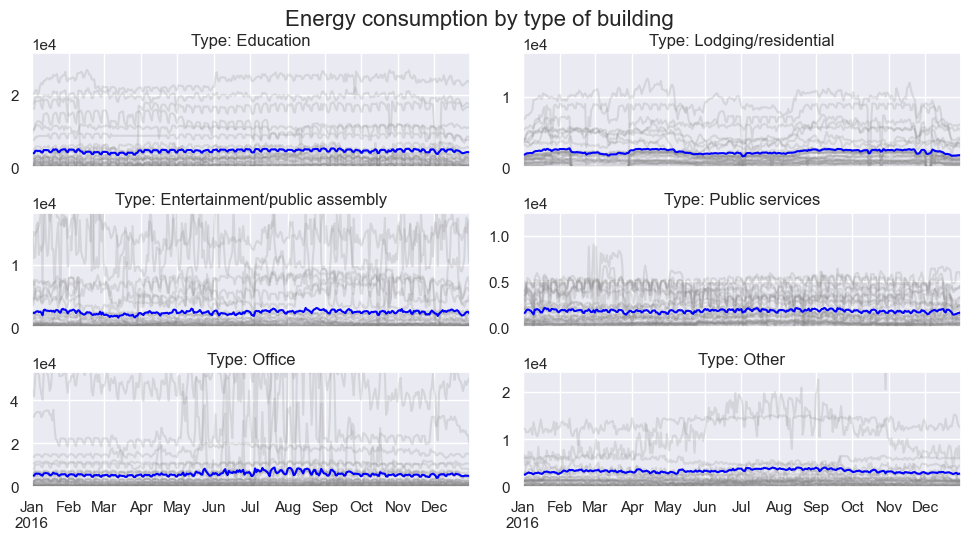

In [9]:
# Energy consumption by type of building (one gray line per building)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 5.5), sharex=True, sharey=False)
axs = axs.flatten()

for i, building_type in enumerate(data['primary_use'].unique()):
    data_sample = data[data['primary_use'] == building_type]
    data_sample = data_sample.pivot_table(
                      index   = 'timestamp',
                      columns = 'building_id',
                      values  = 'meter_reading',
                      aggfunc = 'mean'
                ).sample(n=30, axis=1, random_state=42)
    
    data_sample.plot(
        legend = False,
        title  = f"Type: {building_type}",
        color  = 'gray',
        alpha  = 0.2,
        ax     = axs[i]
    )
    data_sample.mean(axis=1).plot(
        ax     = axs[i],
        color  = 'blue',
    )
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    # Scientific notation for y axis
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # Limit the axis to 5 times the maximum mean value to improve visualization
    axs[i].set_ylim(
        bottom = 0,
        top    = 6 * data_sample.mean(axis=1).max()
    )

fig.tight_layout()
fig.suptitle('Energy consumption by type of building', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

The graph reveals that there is significant variability in consumption patterns among buildings of the same purpose.

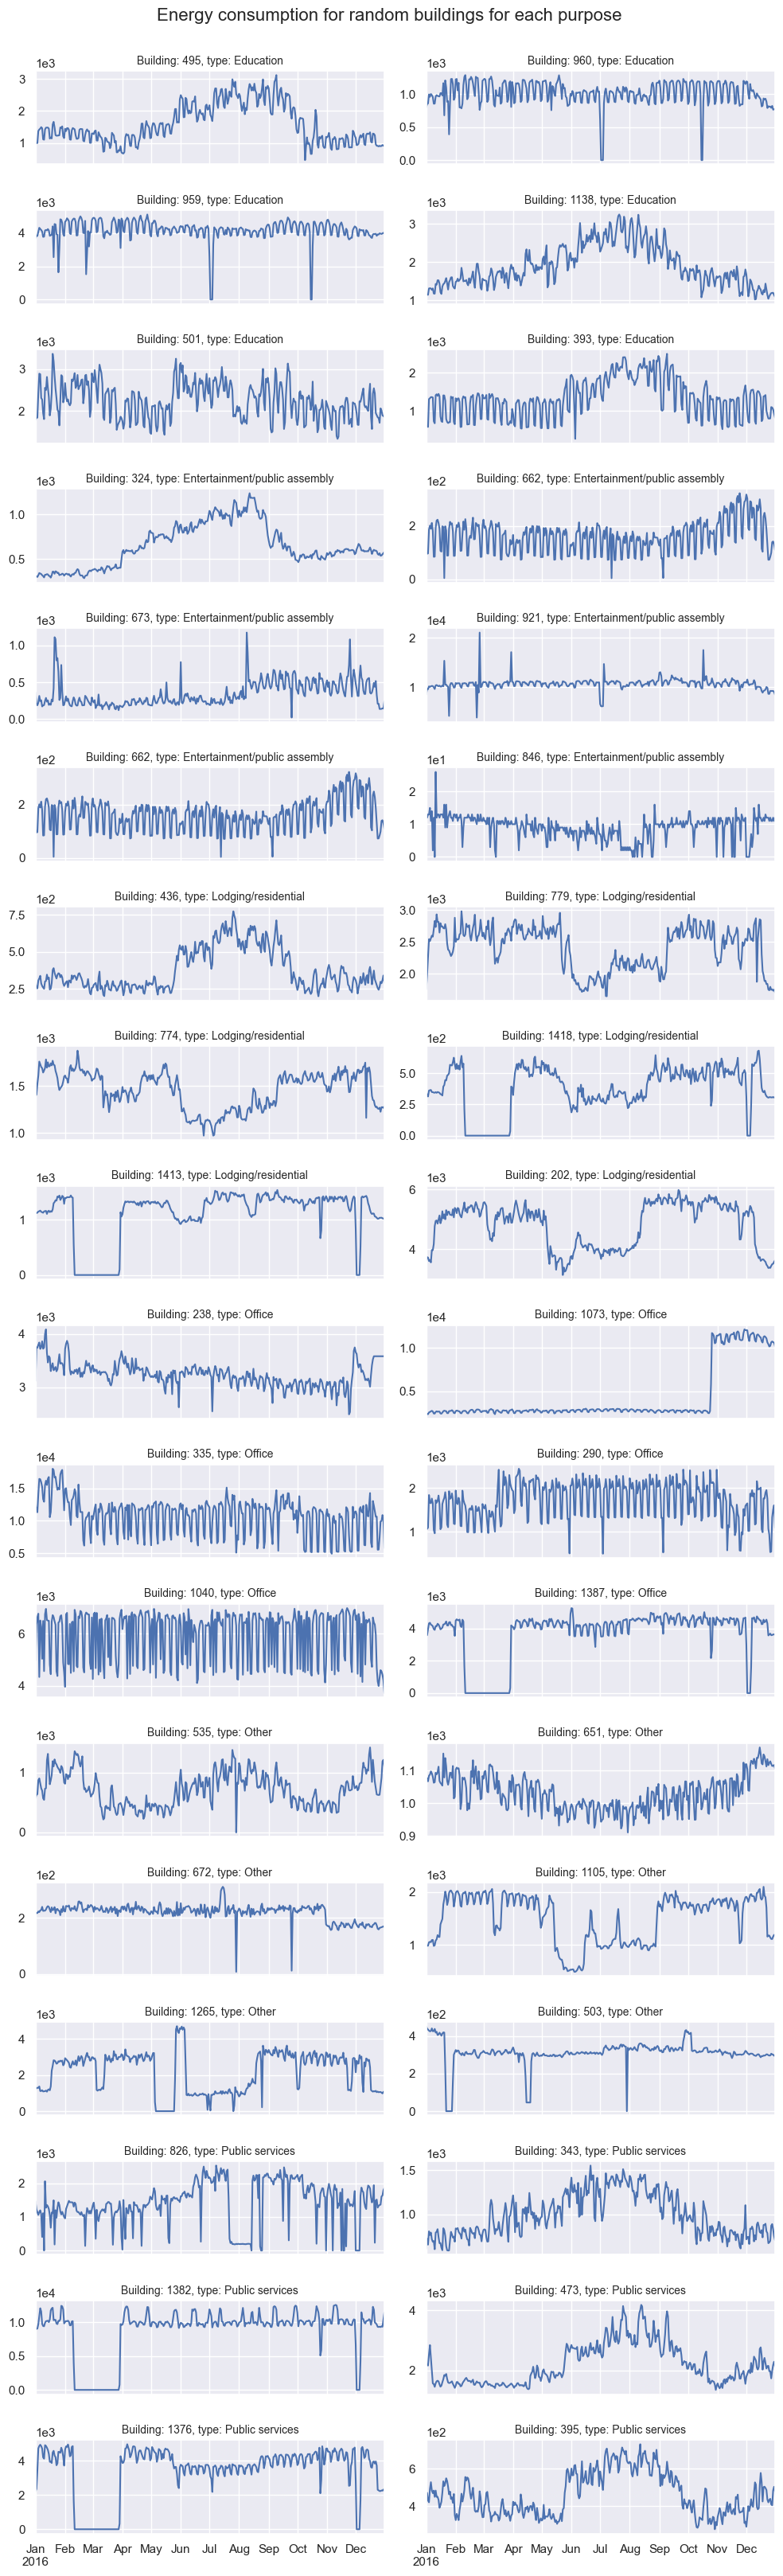

In [103]:
# Time series for 6 random selected building per group
sample_ids = (
    data.groupby("primary_use", observed=True)["building_id"]
    .apply(lambda x: x.sample(6, random_state=42))
    .tolist()
)
start_date = data["timestamp"].min()
end_date = data["timestamp"].max()

fig, axs = plt.subplots(nrows=6*3, ncols=2, figsize=(10, 5.5*6), sharex=True, sharey=False)
axs = axs.flatten()

for i, building_id in enumerate(sample_ids):

    data_sample = data[data["building_id"] == building_id]
    building_type = data_sample["primary_use"].unique()[0]
    data_sample.plot(
        y="meter_reading",
        x="timestamp",
        ax=axs[i],
        legend=False,
        title=f"Building: {building_id}, type: {building_type}",
    )
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    # Scientific notation for y axis
    axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[i].title.set_size(10)
    # Set date range on x axis
    axs[i].set_xlim([start_date, end_date])


fig.suptitle("Energy consumption for random buildings for each purpose \n \n \n", fontsize=16)
fig.tight_layout()
plt.show()

The zero values are actually periods of missing data. After resampling they were
given values of zero. We will treat them as missing data later during modelling.

Each site has multiple buildings. Let's investigate.

In [26]:
# The numner of buildings per site
data.groupby("site_id")["building_id"].nunique()

site_id
0       1
1      51
2     132
3     274
4      90
5      88
6      36
7       9
8      64
9     116
10     30
11      5
12     36
13    138
14     96
15    111
Name: building_id, dtype: int64

Filter out time series with less than 3 months of consecutive data.

In [110]:
len_series = data.value_counts(subset="building_id")
long_series_id = len_series[len_series > 90].index
data = data.query("building_id in @long_series_id")

# Modelling and forecasting

In [65]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

## Feature engineering

Date time features

In [25]:
from feature_engine.datetime import DatetimeFeatures

In [26]:
datetime_trafo = DatetimeFeatures(
    variables=["timestamp"],
    features_to_extract = ["month", "day_of_week", "year", ],
    drop_original=True,
)

Exogenous features

In [27]:
exog_features = [
    "site_id",
    "primary_use",
    "square_feet",
    "year_built",
    "floor_count",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "sea_level_pressure",
    "wind_direction",
    "wind_speed",
]

In [28]:
# Missing data handling on exogenous features
from feature_engine.imputation import ArbitraryNumberImputer

exog_features_numeric = data[exog_features].select_dtypes("number").columns.tolist()

# set up the imputer
arbitrary_imputer = ArbitraryNumberImputer(
    arbitrary_number=-1,
    variables=exog_features_numeric,
    )

# fit the imputer
data = arbitrary_imputer.fit_transform(data)

Categorical features

In [35]:
ordinal_encoder = make_column_transformer(
                    (
                        OrdinalEncoder(
                            handle_unknown='use_encoded_value',
                            unknown_value=-1,
                            encoded_missing_value=-1,
                            dtype=np.int64,
                        ),
                        make_column_selector(dtype_exclude=np.number)
                    ),
                    remainder="passthrough",
                    verbose_feature_names_out=False,
                ).set_output(transform="pandas")

Window and lag features

In [120]:
# Define a function to extract lag and window features
# See: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/custom-predictors.html
def create_predictors(y):
    """
    Create first 7 lags of a time series.
    Calculate rolling mean and standard deviation with window 7 and 30.
    """

    lags = y[-1:-100:-1]  # window_size = 8
    mean_7 = np.mean(y[-7:])  # window_size = 7
    std_7 = np.std(y[-7:])

    predictors = np.hstack([lags, mean_7, std_7])

    return predictors


name_predictors = [f"lag_{i}" for i in range(1, 100)] + [
    "mean_7",
    "std_7",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32',
 'lag_33',
 'lag_34',
 'lag_35',
 'lag_36',
 'lag_37',
 'lag_38',
 'lag_39',
 'lag_40',
 'lag_41',
 'lag_42',
 'lag_43',
 'lag_44',
 'lag_45',
 'lag_46',
 'lag_47',
 'lag_48',
 'lag_49',
 'lag_50',
 'lag_51',
 'lag_52',
 'lag_53',
 'lag_54',
 'lag_55',
 'lag_56',
 'lag_57',
 'lag_58',
 'lag_59',
 'lag_60',
 'lag_61',
 'lag_62',
 'lag_63',
 'lag_64',
 'lag_65',
 'lag_66',
 'lag_67',
 'lag_68',
 'lag_69',
 'lag_70',
 'lag_71',
 'lag_72',
 'lag_73',
 'lag_74',
 'lag_75',
 'lag_76',
 'lag_77',
 'lag_78',
 'lag_79',
 'lag_80',
 'lag_81',
 'lag_82',
 'lag_83',
 'lag_84',
 'lag_85',
 'lag_86',
 'lag_87',
 'lag_88',
 'lag_89',
 'lag_90',
 'lag_91',
 'lag_92

## Modelling

In [113]:
train_start_date = data.timestamp.max() - pd.Timedelta("14D")

In [114]:
data_train = data.query("timestamp < @train_start_date")
data_test = data.query("timestamp >= @train_start_date")

In [116]:
# Train
series_dict_train = series_long_to_dict(
    data=data_train,
    series_id="building_id",
    index="timestamp",
    values="meter_reading",
    freq="D",
)

exog_dict_train = exog_long_to_dict(
    data=data_train[exog_features + ["building_id", "timestamp"]] ,
    series_id="building_id",
    index="timestamp",
    freq="D",
)

# Test
series_dict_test = series_long_to_dict(
    data=data_test,
    series_id="building_id",
    index="timestamp",
    values="meter_reading",
    freq="D",
)

exog_dict_test = exog_long_to_dict(
    data=data_test[exog_features + ["building_id", "timestamp"]] ,
    series_id="building_id",
    index="timestamp",
    freq="D",
)

In [119]:
# Create Matrices, dropna_from_series = False
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)

# Lag features only
# forecaster = ForecasterAutoregMultiSeries(
#                  regressor          = regressor, 
#                  lags               = 3, 
#                  encoding           = "ordinal", 
#                  dropna_from_series = False,
#                  transformer_series = None,
#                  transformer_exog = ordinal_encoder,
#              )

# Custom features (e.g., lag and window features)
forecaster = ForecasterAutoregMultiSeriesCustom(
    regressor=regressor,
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=100,  # Largest window size needed by `create_predictors`
    encoding = "ordinal",
    transformer_series=None,
    transformer_exog=ordinal_encoder,
    dropna_from_series = False,
)


X_train, y_train = forecaster.create_train_X_y(series=series_dict_train, exog=exog_dict_train)

display(pd.concat([X_train, y_train], axis=1).head(3))

print("Observations per series:")
print(X_train['_level_skforecast'].value_counts())

print("NaNs per series:")
print(X_train.isnull().sum())

print("Number of series:")
print(X_train["_level_skforecast"].nunique())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,_level_skforecast,...,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,y
2016-01-13,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.714002,-0.763171,-0.756147,1.720559e-02,0,...,2006,-1,11.741667,6.400000,0.487500,0.000000,1022.916667,277.083333,3.308333,-0.763171
2016-01-14,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.714002,-0.756147,1.720559e-02,0,...,2006,-1,13.104167,7.000000,5.733333,0.000000,1021.291667,147.500000,3.283333,-0.763171
2016-01-15,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,-0.763171,5.960464e-08,0,...,2006,-1,18.712500,5.714286,15.091667,9.333333,1011.382609,162.083333,4.783333,-0.763171


Observations per series:
_level_skforecast
638     344
842     344
849     344
848     344
847     344
       ... 
886     118
512     106
482      99
312      90
1165     72
Name: count, Length: 1276, dtype: int64
NaNs per series:
lag_1                 0
lag_2                 0
lag_3                 0
lag_4                 0
lag_5                 0
lag_6                 0
lag_7                 0
mean_7                0
std_7                 0
_level_skforecast     0
primary_use           0
site_id               0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64
Number of series:
1276


In [40]:
forecaster.fit(series=series_dict_train, exog=exog_dict_train)

In [49]:
y_pred = forecaster.predict(steps=14, exog=exog_dict_test, suppress_warnings=True)

/Users/kishan_manani/.pyenv/versions/3.10.2/envs/fcst-ml/lib/python3.10/site-packages/skforecast/utils/utils.py:485: DataTypeWarning: `exog` for series '29' may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/Users/kishan_manani/.pyenv/versions/3.10.2/envs/fcst-ml/lib/python3.10/site-packages/skforecast/utils/utils.py:485: DataTypeWarning: `exog` for series '105' may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/Users/kishan_manani/.pyenv/versions/3.10.2/envs/fcst-ml/lib/python3.10/site-packages/skforecast/utils/utils.py:485: DataTypeWarning: `exog` 

/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_45468/1134595436.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_train.groupby("primary_use")["building_id"]


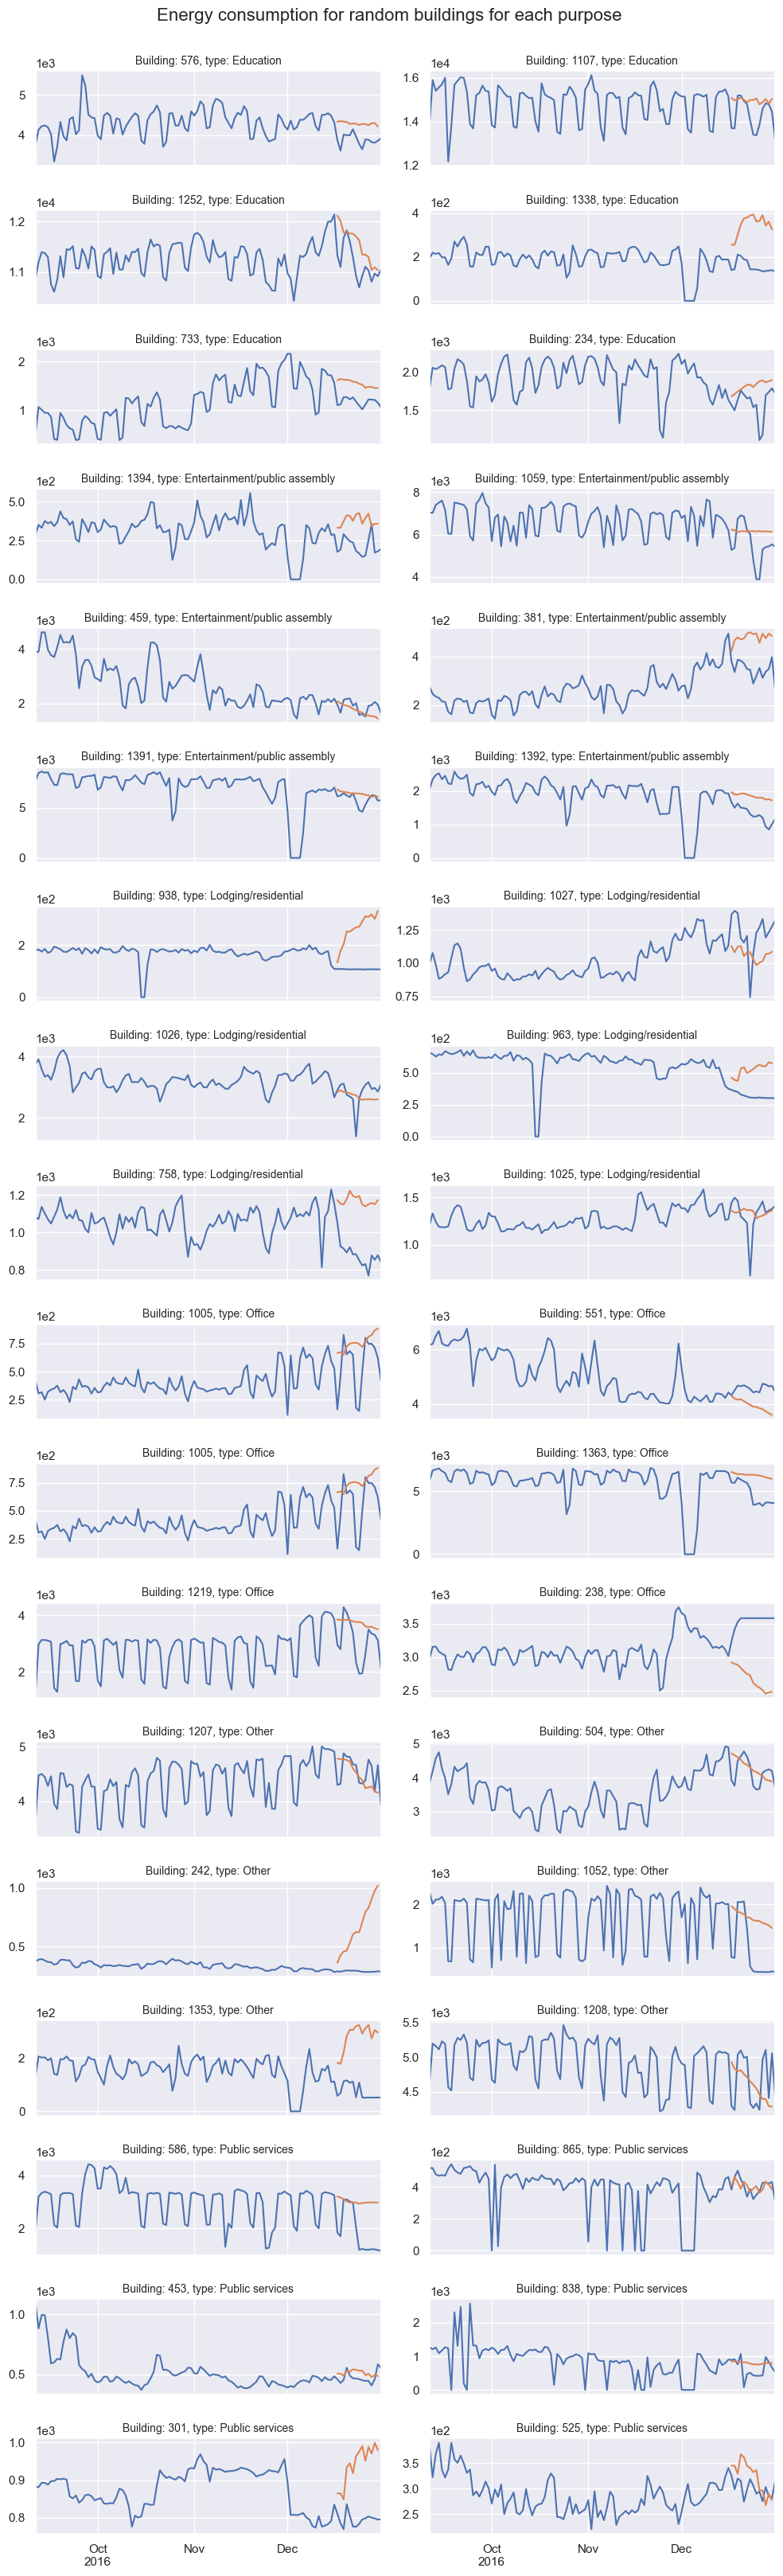

In [51]:
# Time series for 6 random selected building per group
sample_ids = (
    data_train.groupby("primary_use")["building_id"]
    .apply(lambda x: x.sample(6, random_state=42))
    .tolist()
)

fig, axs = plt.subplots(nrows=6*3, ncols=2, figsize=(10, 5.5*6), sharex=True, sharey=False)
axs = axs.flatten()

for i, building_id in enumerate(sample_ids):

    data_sample = data[data["building_id"] == building_id]
    building_type = data_sample["primary_use"].unique()[0]
    data_sample.iloc[-7*4*4:].plot(
        y="meter_reading",
        x="timestamp",
        ax=axs[i],
        legend=False,
        title=f"Building: {building_id}, type: {building_type}",
    )
    y_pred[building_id].plot(ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    # Scientific notation for y axis
    axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[i].title.set_size(10)

fig.suptitle("Energy consumption for random buildings for each purpose \n \n \n", fontsize=16)
fig.tight_layout()
plt.show()

In [64]:
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict_train,
    exog                  = exog_dict_train,
    levels                = None,
    steps                 = 24,
    metric                = "mean_absolute_error",
    initial_train_size    = 200,
    fixed_train_size      = True,
    gap                   = 0,
    allow_incomplete_fold = True,
    refit                 = False,
    n_jobs                ="auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 200
Number of observations used for backtesting: 151
    Number of folds: 7
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 7 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-07-18 00:00:00  (n=200)
    Validation: 2016-07-19 00:00:00 -- 2016-08-11 00:00:00  (n=24)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2016-07-18 00:00:00  (n=200)
    Validation: 2016-08-12 00:00:00 -- 2016-09-04 00:00:00  (n=24)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2016-07-18 00:00:00  (n=200)
    Validation: 2016-09-05 00:00:00 -- 2016-09-28 00:00:00  (n=24)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2016-07-18 00:00:00  (n=200)
    Validation: 2016-09-29 00:00:00 -- 2016-10-22 00:00:00  (n=24)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2016-07-18 00:00:00  (n=

  0%|          | 0/7 [00:00<?, ?it/s]

TypeError: float() argument must be a string or a real number, not 'NAType'

In [ ]:
metrics_levels

Timedelta('365 days 00:00:00')